# Secured Telemetry by Time-Variant Sensing Matrix

# Add gaussian/pepper-salt/poisson noise in GUI

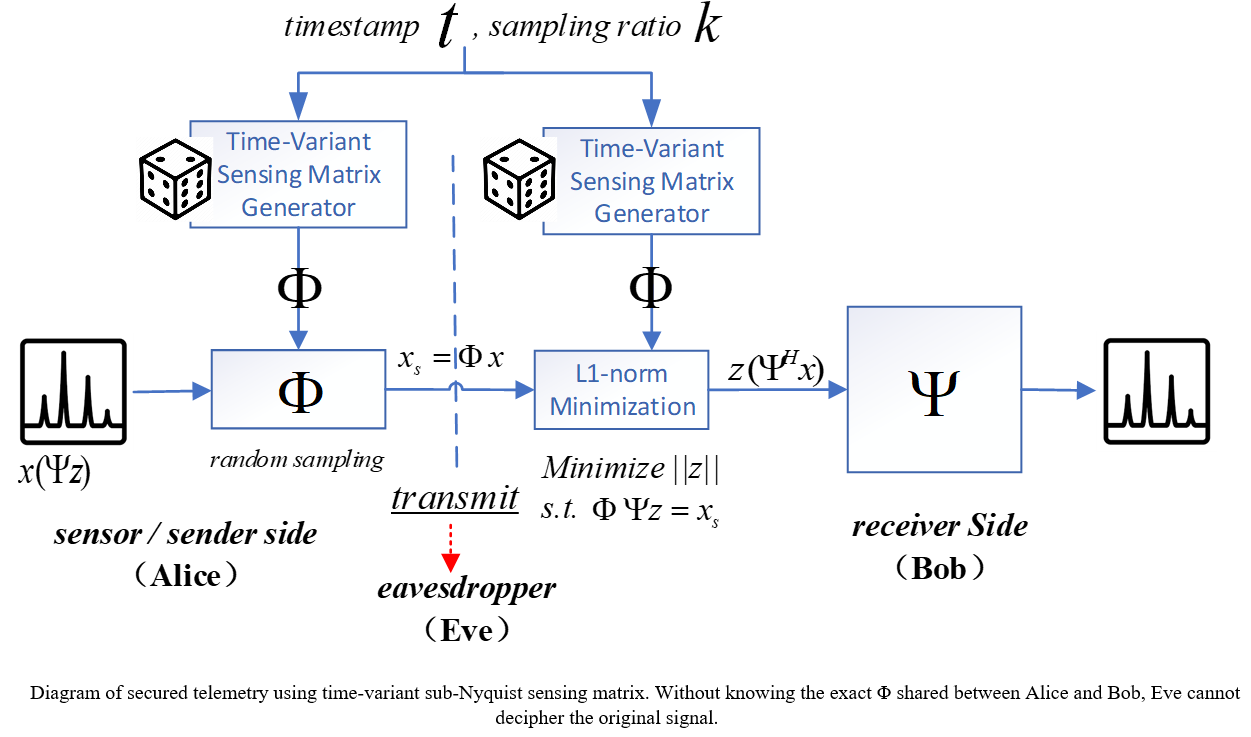

# Install 

This code uses our 'cs1' package (https://github.com/zhangys11/cs1)   

```pip install cs1```

You also need to install our 'qsi-tk' package to use the data I/O functions,  

```pip install qsi-tk```

# Load Data

load dataset from 734b.csv
X.shape (15, 2090)


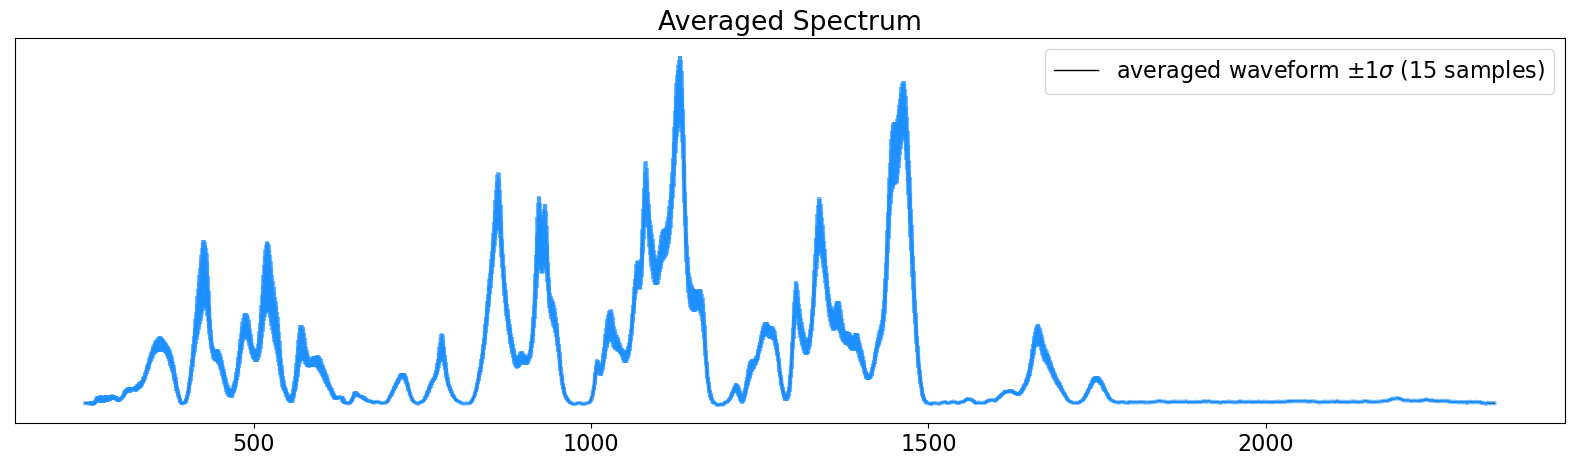

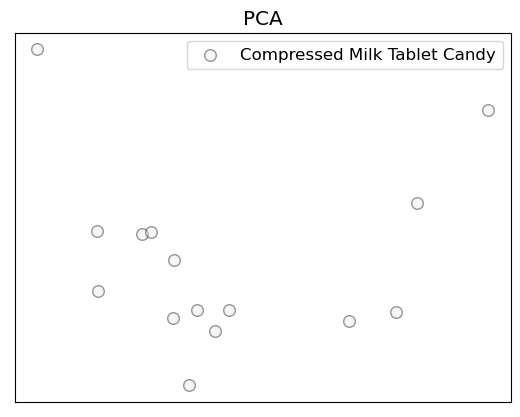

Column Meanings: Raman shift / wavenumber (cm-1). Range: 250~2339
Each row is one sample. 
Total 15 sampless

  X meaning: drift time
  X range: 0 ~ 31 ms
  Resolution: 0.02 ms / 20 us

* Data Source: Compressed Milk Tablet Candy, with Calcium and Vitamin A,D additives
* Source: Heilongjiang Province, China.
-------------------------
Internal Source ID 734b
Edit date: Jan 13, 2020


In [1]:
from qsi import io
X, y, X_names, _, labels = io.load_dataset('milk_tablet_candy')

## Core Compressed Sensing (CS) Process**

Sampling  
$ x_s = \Phi x $

Sparsity hypothesis  
$ x = \Psi z $

Compressed Sensing / sub-Nyquist Sampling   
$ x_s = \Phi \Psi z $

Reconstruction of latent z    
$ minimize \quad  ||z||_1 \quad s.t. \quad     x_s = \Phi \Psi z $

Inverse-transform to orginal space    
$ x = \Psi z $

## Generating Sensing Matrix

(-0.5, 2089.5, 417.5, -0.5)

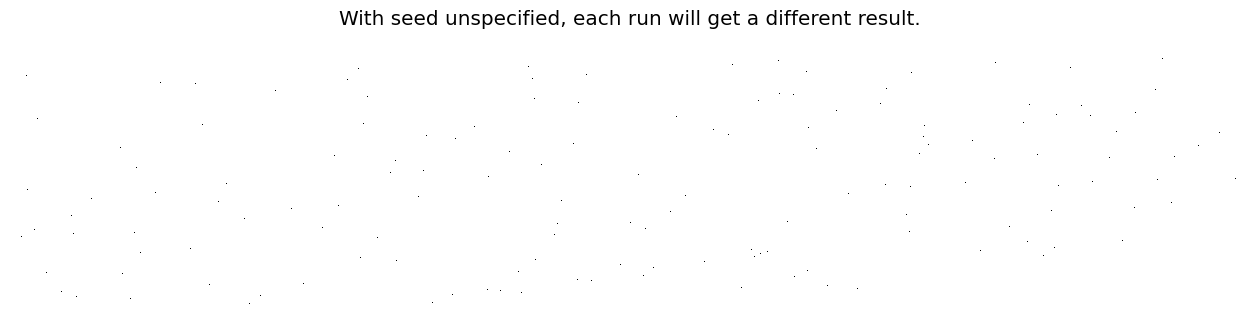

In [2]:
from cs1 import cs
import matplotlib.pyplot as plt
from matplotlib import cm

m,n = X.shape
PHI, OMEGA = cs.GetSensingMatrix(n, k = 0.2, s = None)

# plt.figure(figsize = (12,3))
plt.matshow(PHI, interpolation='nearest', cmap=cm.Greys)
plt.title('With seed unspecified, each run will get a different result.')
plt.axis('off')

### Conversion between timestamp and seed (integer)

Unix and POSIX measure time as the number of seconds that have passed since 1 January 1970 00:00:00 UT, a point in time known as the Unix epoch. The NT time epoch on Windows NT and later refers to the Windows NT system time in (10^-7)s intervals from 0h 1 January 1601.

In [3]:
import cs1.security.tvsm

s = cs1.security.tvsm.Time2Seed()
print(s)

1685766792


In [4]:
cs1.security.tvsm.Seed2Time(s)

'Sat Jun  3 12:33:12 2023'

# Perform CS sensing and reconstruction on the entire dataset

For details of CS, refer to [Compressed Sening.ipynb]

In [5]:
# Load PSIs back from pickle. The pickle is created by cs.Generate_PSIs().
import pickle

m, n = X.shape
file = open('PSIs_' + str(n) + '.pkl','rb')
PSIs = pickle.load(file)
file.close()

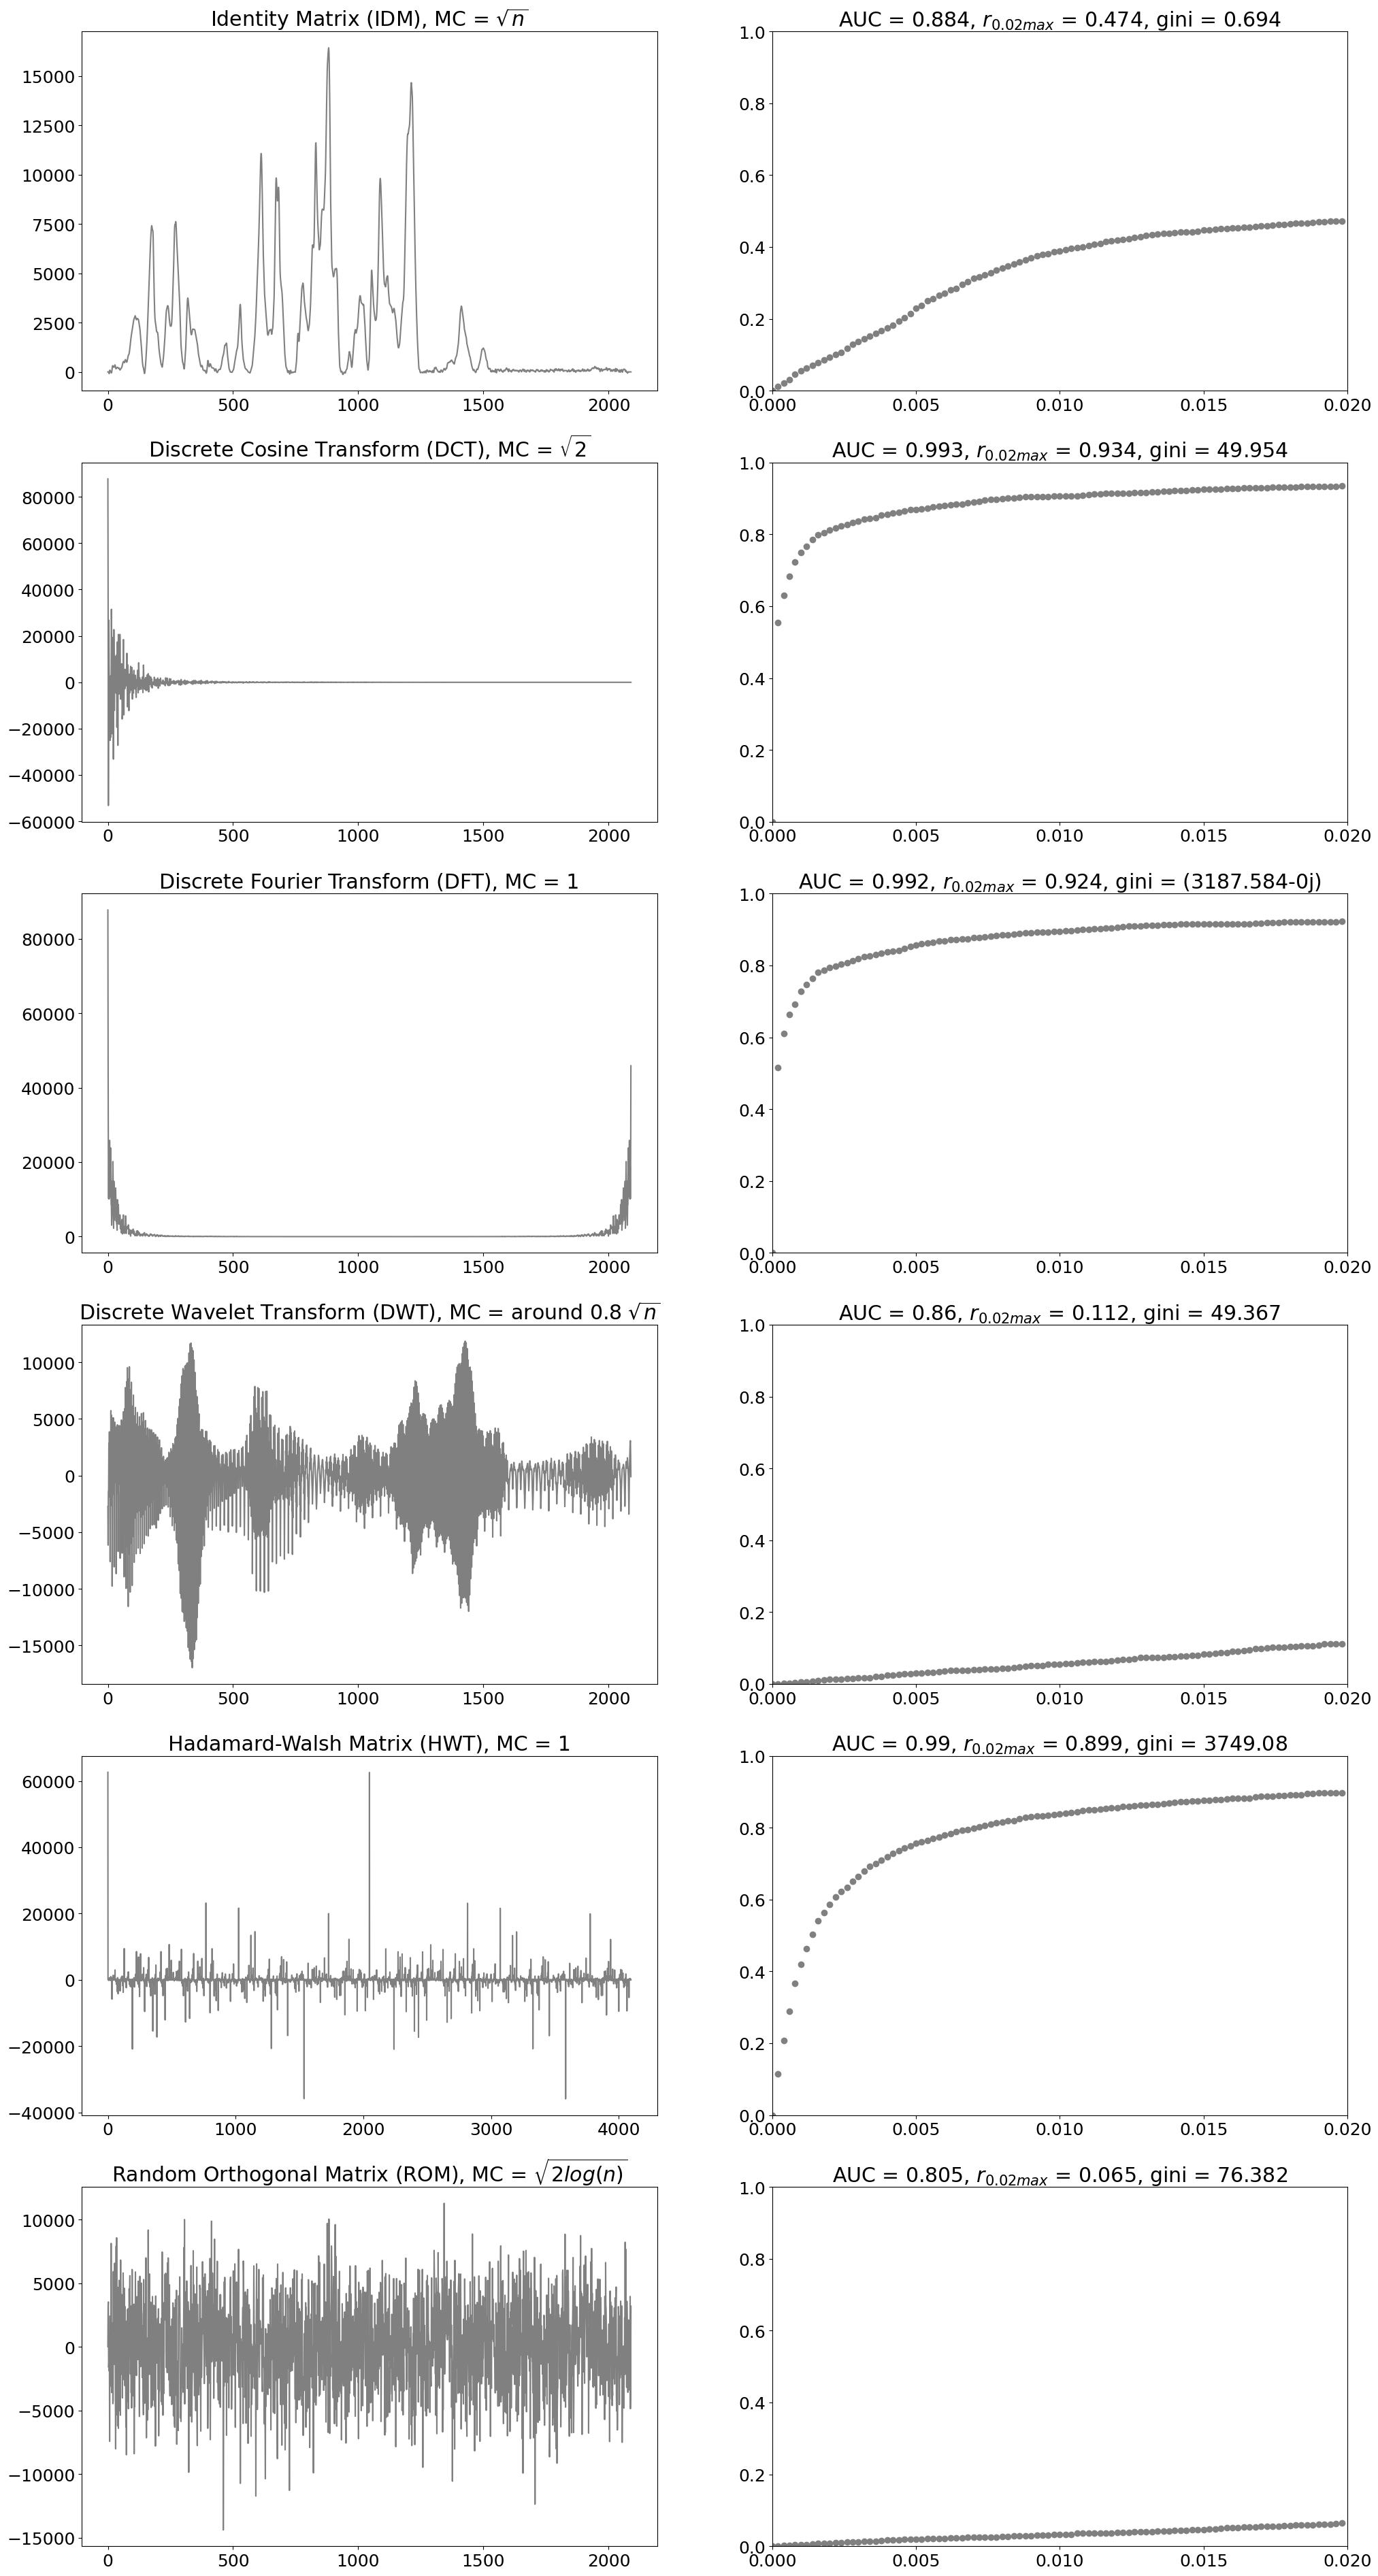

In [6]:
import cs1.metrics
cs1.metrics.analyze_sparsity(X[0], PSIs)

## Visualize all samples



===== Ψ = IDM, k =0.1 ======

Sample 1


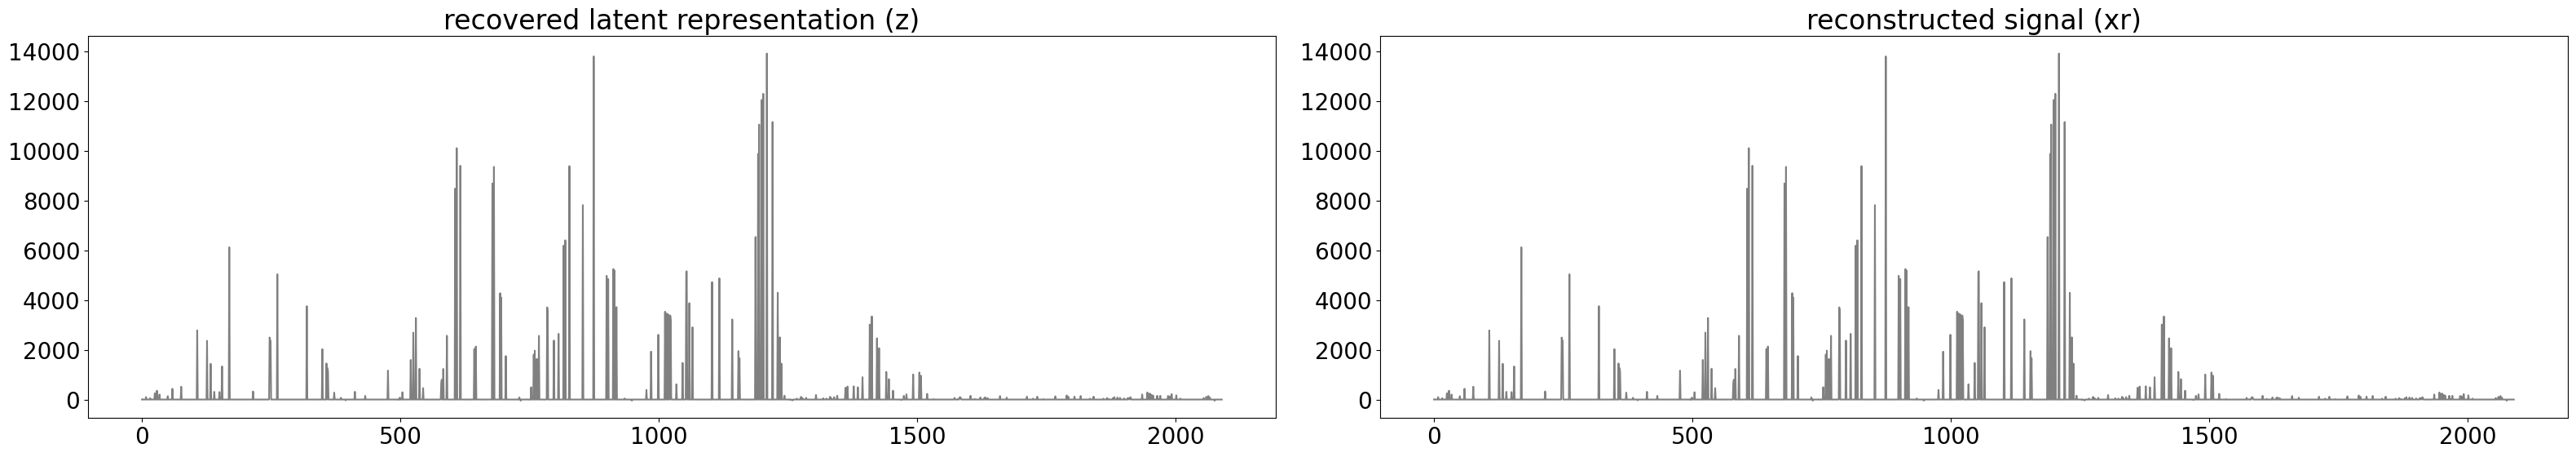

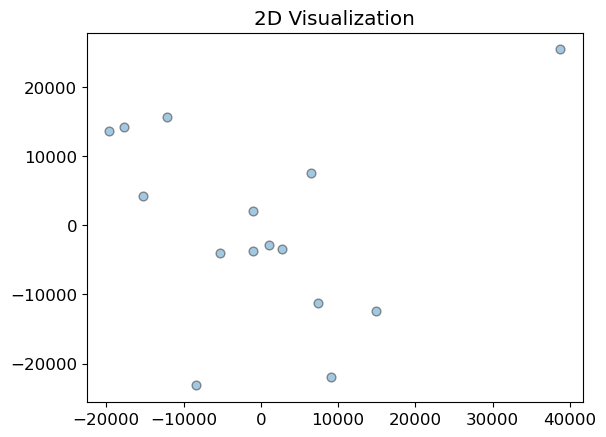



===== Ψ = IDM, k =0.5 ======

Sample 1


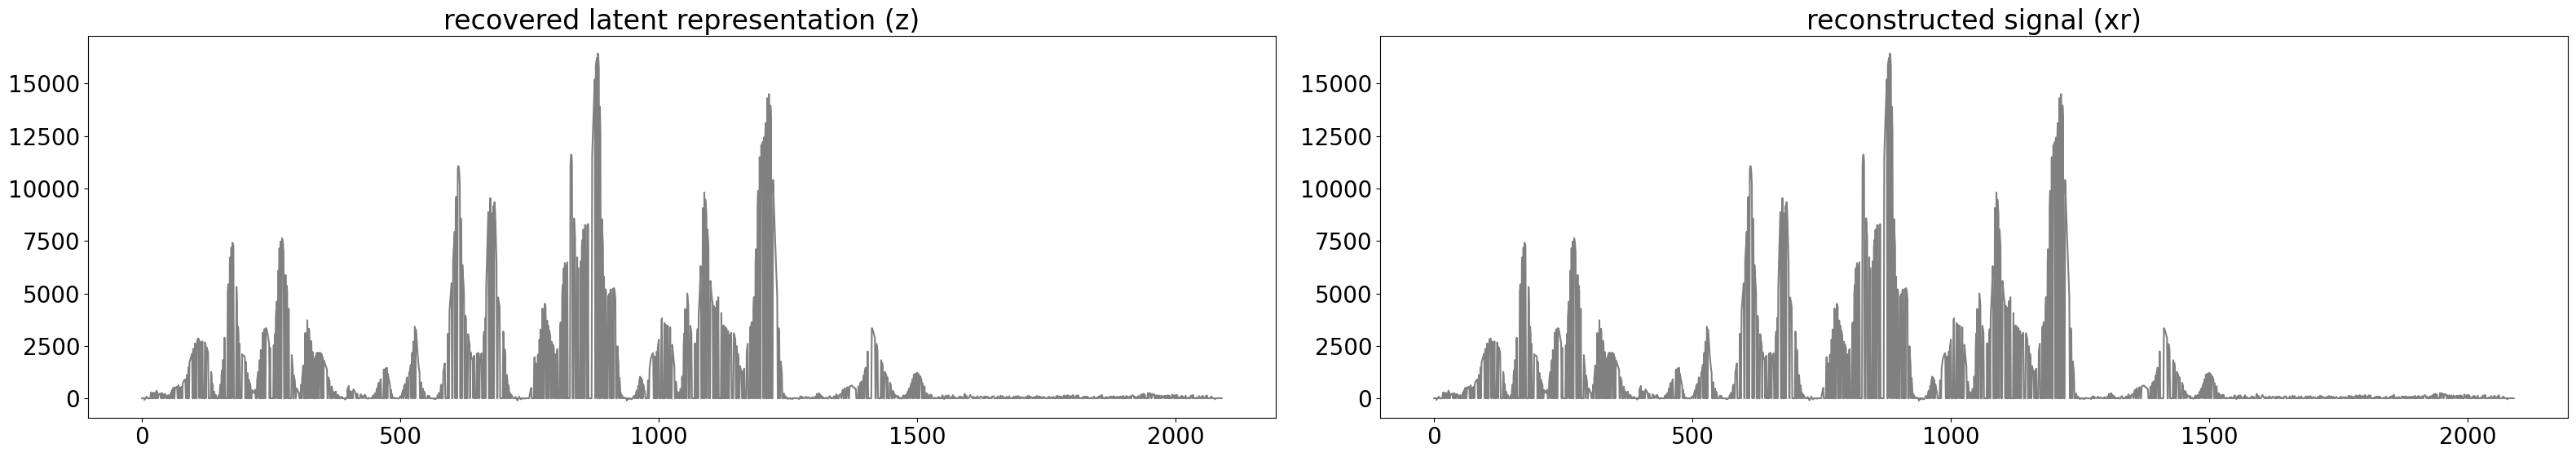

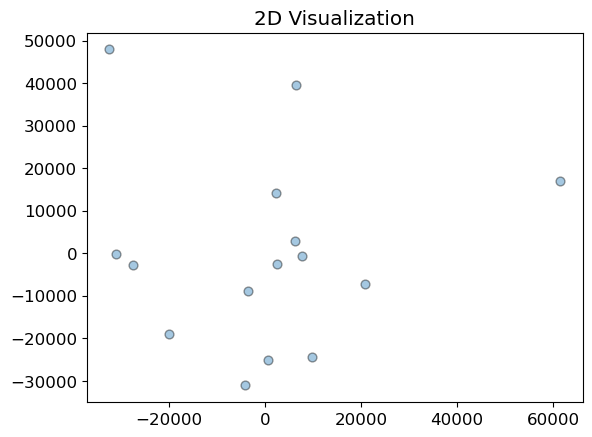



===== Ψ = DCT, k =0.1 ======

Sample 1


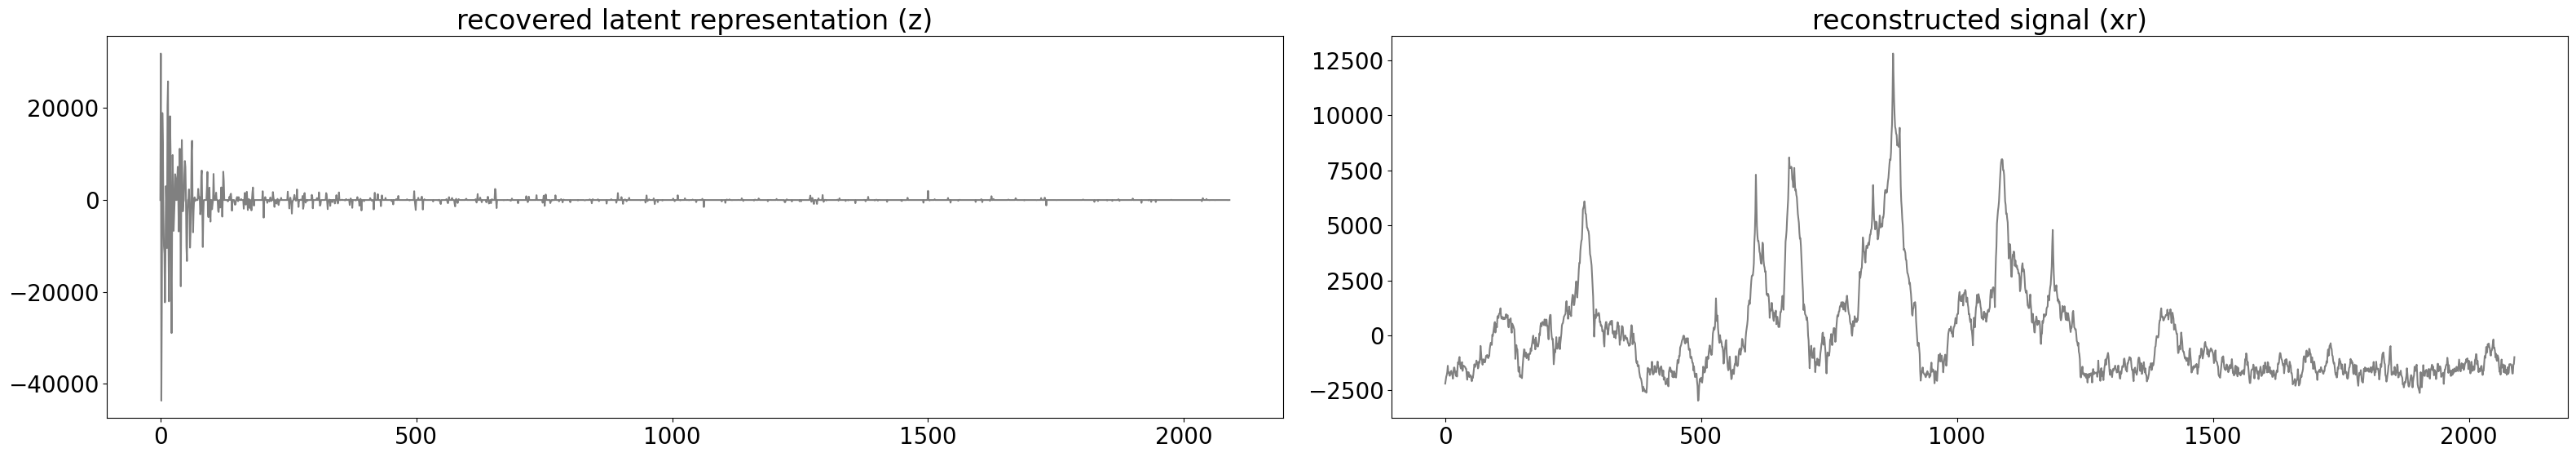

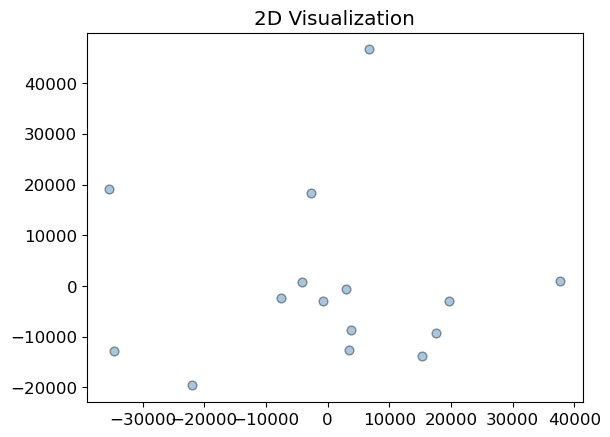



===== Ψ = DCT, k =0.5 ======

Sample 1


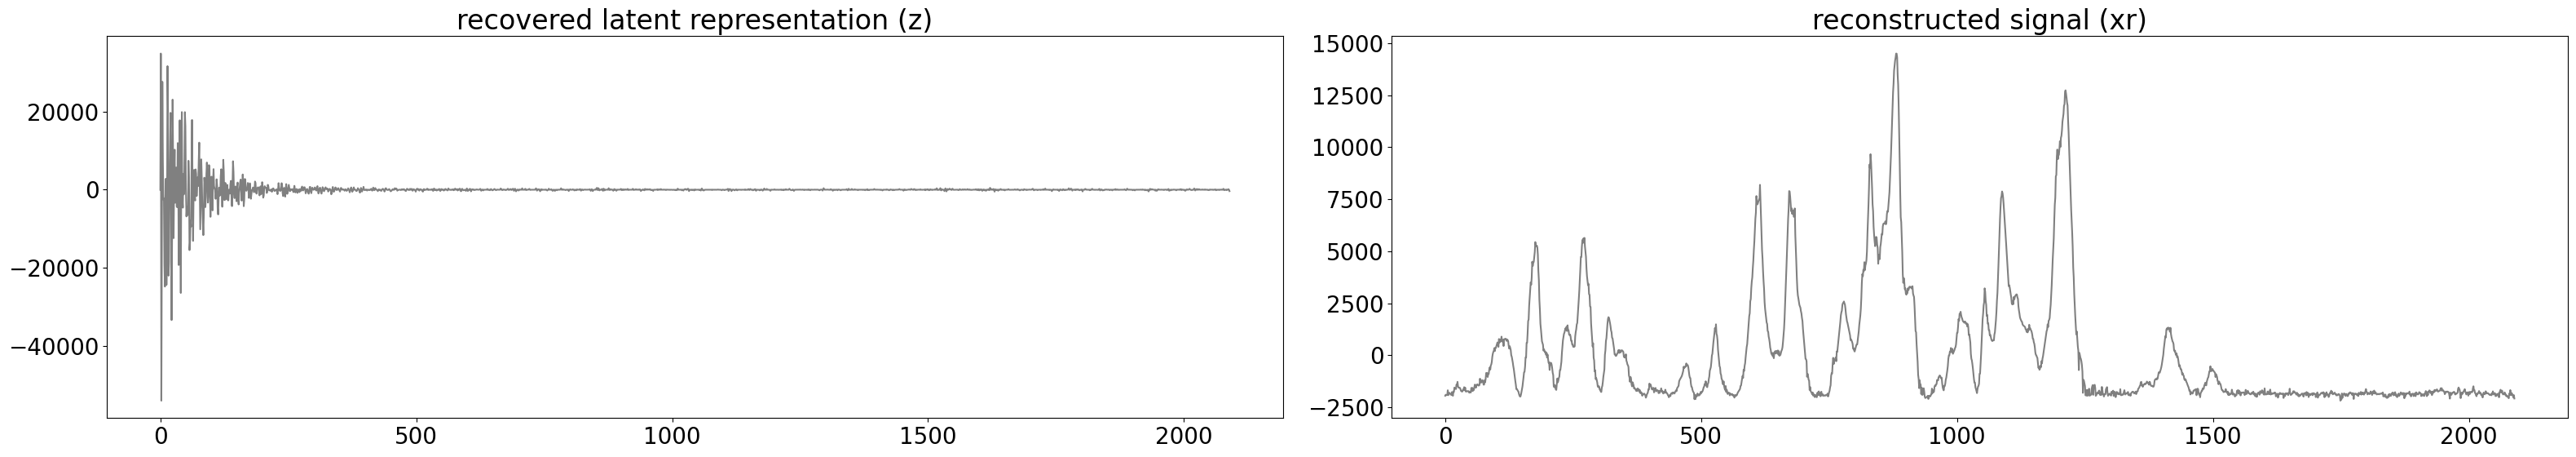

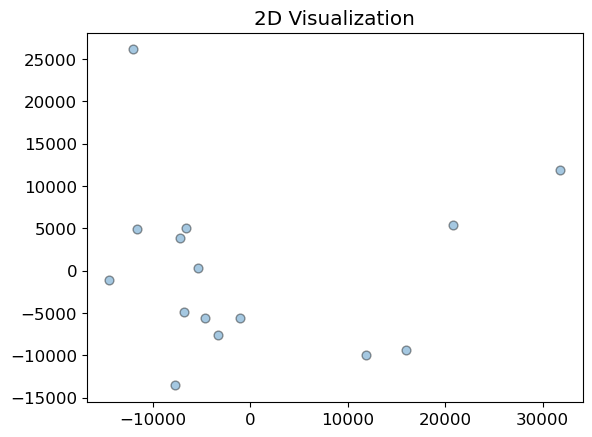

In [7]:
for t in ['IDM', 'DCT']:
    for k in [0.10, 0.50]:        
        _ = cs.Dataset_Sensing_n_Recovery (X, k = k, t = t, solver = 'LASSO', display = 'first')

Several phenomena can be observed. 1) For Ψ = IDM, z = xr. This case equals performing sampling and reconstruction directly in the original space. 2) The reconstruction result of HWT is noisier and “spikier” than DCT and DFT. 3) When k is small (e.g., 0.01, or only 1% information is sampled), the reconstruction error is significant. By increasing k, the error goes down. 4) For k >= 0.1, both DCT and DFT demonstrate decent reconstruction results, though DFT is “spikier” at certain positions than DCT. 

## Best hyper-parameters for the Raman dataset

PSI = "DFT", k = 0.3

# Security Verification

In this part, we simulate a security senario: a hacker intercepts our transmmitted signal xs. He/she tries to guess the sensing matrix and reconstruct the signal with the brute-force method.

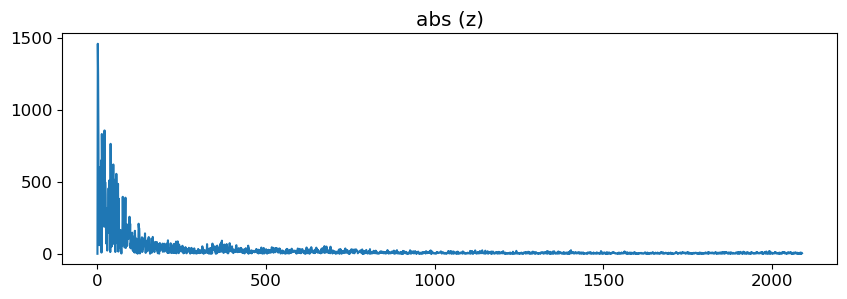

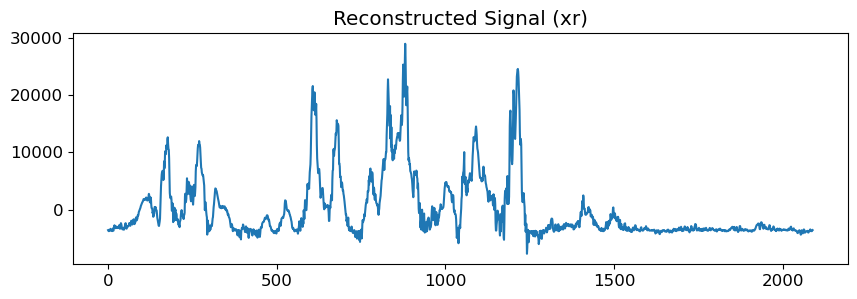

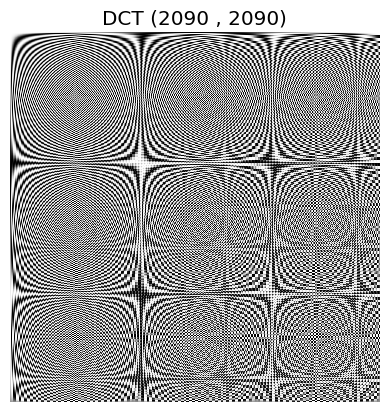

AUC =  0.993 
sparsity =  0.934


In [8]:
import cs1.basis.common
import numpy as np
from cs1 import cs

k = 0.3
t='DFT'
N = len(X[0])

xs, idx_g = cs.Sensing(X[0], k) # idx is the sensing indices. It is an eqaulivalent representation for the senging matrix.

A = cs.MeasurementMatrix (N, idx_g, t)
xr_g, _ = cs.Recovery (A, xs, t = t)

z_g = cs1.basis.common.dctmtx(N, N) @ X[0]

MAX = abs(max(z_g, key=abs))

auc = 0
for i in range(1000):
    auc += (np.abs(np.array(z_g)) <= (i+1)/1000 * MAX).sum() / len(z_g)        
auc = auc/1000

r = (np.abs(np.array(z_g)) <= 0.02 * MAX).sum() / len(z_g)  # use 0.01 MAX ABS as threshold    

print('AUC = ', round(auc, 3), '\nsparsity = ', round(r, 3))

idx is the sensing indices. It is an eqaulivalent representation for the senging matrix.   
During the data transmission, idx is not transfered (will be generated by the internal TVSMG on both sides).   

With the intercepted signal xs, the hacker try to guess the sensing matrix (idx).  

In [9]:
import cs1.security.tvsm
cs1.security.tvsm.brute_force_total_guesses(N, len(xs), verbose = True)

N =  2090 , K =  627
A(N,K) in log10 =  2036.1280922561273
Total years needed to iterate all combinations (in log10) =  2028.6289882890421


2036.1280922561273

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:54<00:00,  4.27it/s]

Best AUC =  0.86 
sparsity =  0.088


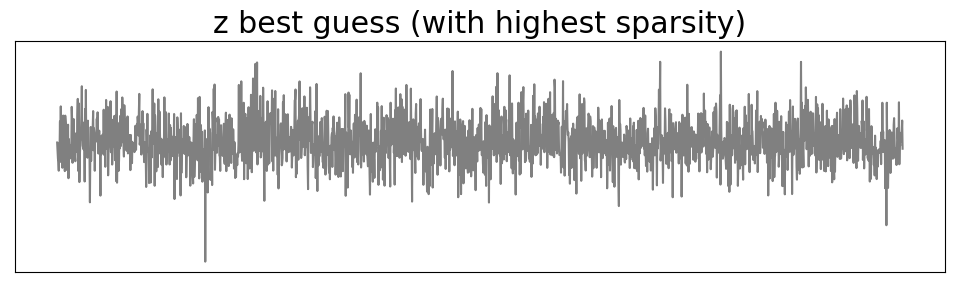

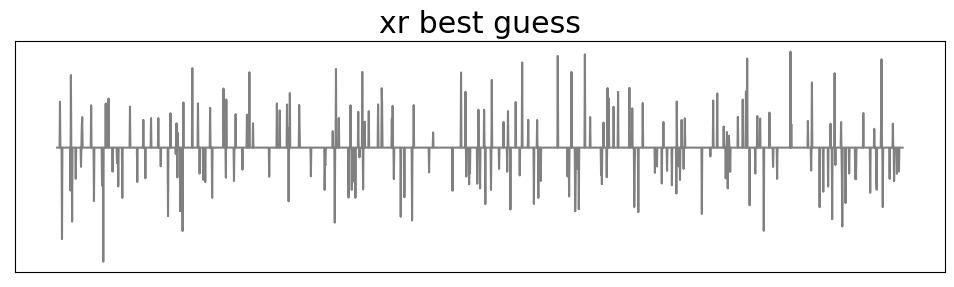

(array([ -145.57148687, -1405.63968004, -2667.42704223, ...,
         1799.74622902,  3283.22377044, -1113.30340779]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [10]:
cs1.security.tvsm.brute_force_guess(xs, N, t = 'DCT', solver = 'OMP', ITER = 1000)

Each iteration costs about 5 second on the current workstation. CPU: 2.2G × 6 Cores, Memory: 24 GB

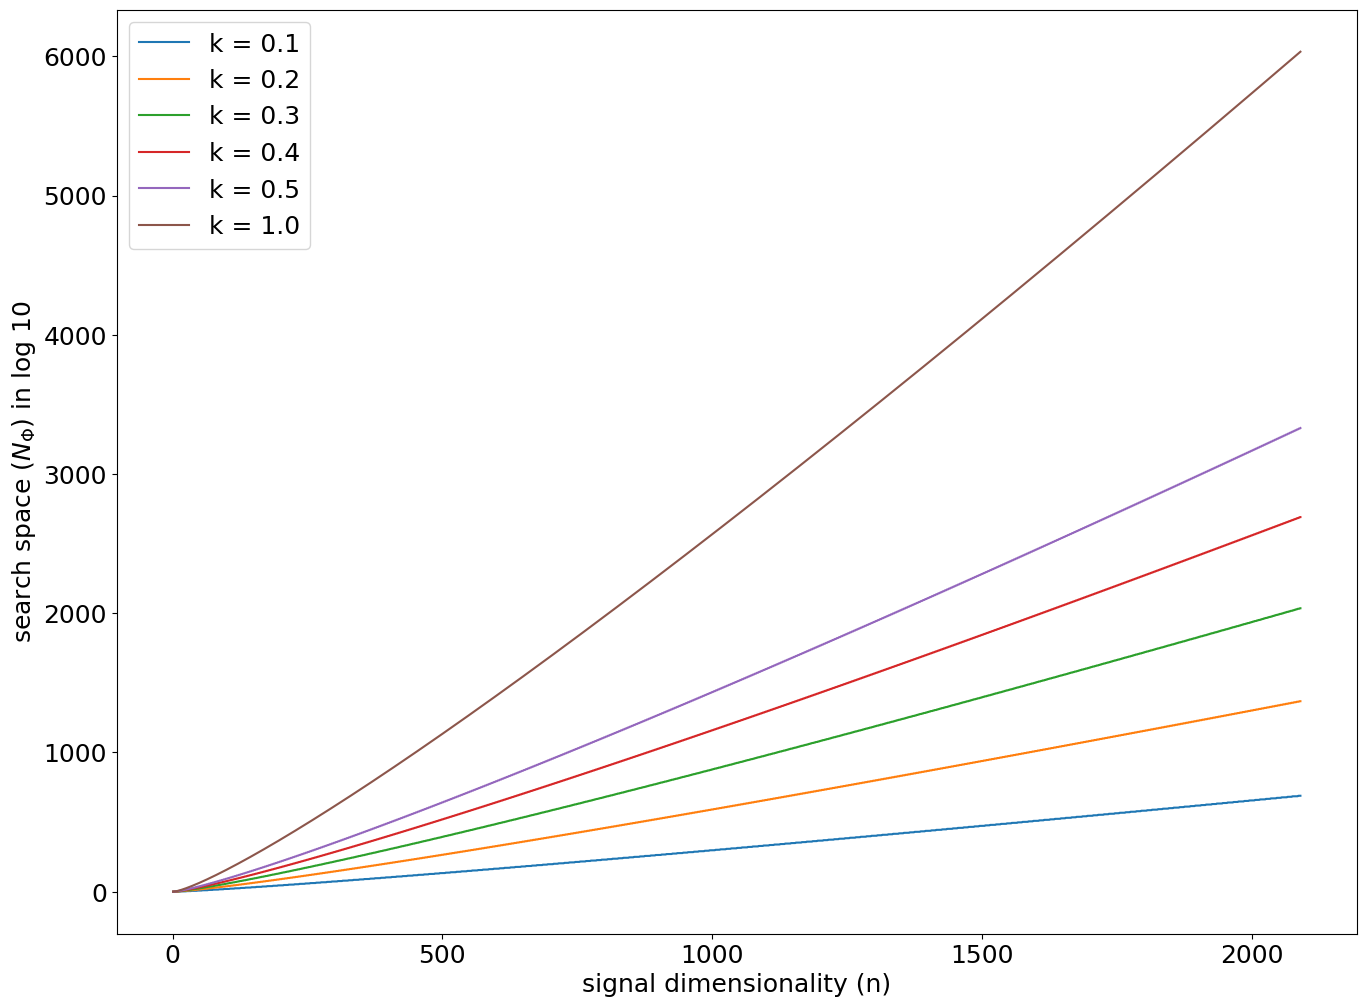

In [11]:
import cs1.security.tvsm
cs1.security.tvsm.brute_force_guess_plot(N)

# Appendix

## 1. Github (http://github.com/zhangys11/cs1)

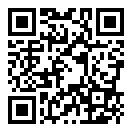

## 2. A CS web demo (http://qsi.zhangys.org.cn/CS)

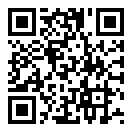

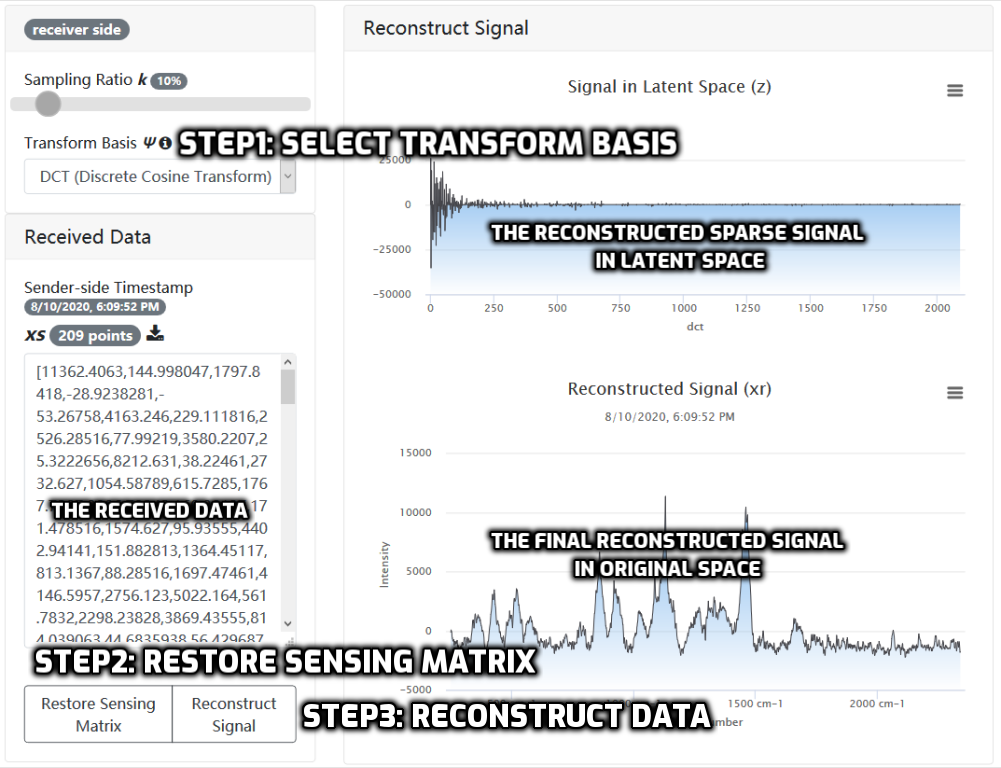